In [2]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Masking
import keras_tuner as kt
from pathlib import Path
import joblib # for saving and loading variables
import io
import contextlib
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report, balanced_accuracy_score

In [2]:
#cur_el = joblib.load('it.sav')

In [3]:
cur_el = 1

In [4]:
base_folder = Path('C:/Users/ilkele4s/')

main_results_folder = Path('ML_Results/LSTM_noFunction_singleElectrode_results')
new_results_folder = 'electrode_' +str(cur_el)

data_folder = Path('Data/Electrodes')
data_file = 'electrode_' +str(cur_el) + '.csv'

tune_folder = 'Tune'
project_name = 'Random_30'

In [6]:
results_dir = os.path.join(base_folder,main_results_folder)

new_results_dir = os.path.join(results_dir,new_results_folder)

In [9]:
os.mkdir(new_results_dir)

print(new_results_dir)

C:\Users\ilkele4s\ML_Results\LSTM_noFunction_singleElectrode_results\electrode_1


In [10]:
tune_dir = os.path.join(new_results_dir,tune_folder)

In [11]:
# load the data 
data_dir = os.path.join(base_folder,data_folder)

data_file_path = os.path.join(data_dir,data_file)

print(data_file_path)

Data = pd.read_csv(data_file_path, header = None)

C:\Users\ilkele4s\Data\Electrodes\electrode_1.csv


In [12]:
np.shape(Data) # samples, features

(1440, 300)

In [13]:
# structure samples for LSTM

data_array = np.array(Data)

n_samples = data_array.shape[0]
n_features = data_array.shape[1]

bin_cur = 1
bin_past = 3

bins_predict = bin_cur + bin_past # 3 previous + 1 current

formatted_data = np.zeros([n_samples,bins_predict,n_features])

start_idx=0
for i in range(n_samples-bin_past):
    end_idx=start_idx+bins_predict # indices for 4 elements (sliding fashion)
    formatted_data[i+bin_past,:,:]=data_array[start_idx:end_idx,:] # indexing the data with indices from the previous step
    start_idx=start_idx+1

In [14]:
formatted_data[np.isnan(formatted_data)] = 0 # replacing nans with zeros

In [15]:
# create a label set

n_zones = 45
n_trials = 32

## one-hot-encoding 
cat_zones = keras.utils.to_categorical(np.r_[1:n_zones+1] ,num_classes=46) # one-hot-encoding 
cat_zones = np.delete(cat_zones,0,1)

## repeating the labels for 32 (no_of trial) times
labels_all_trials = np.tile(cat_zones, 32) 


## reshaping the data from  (45,1440) to (1440,45)
reshaped_labels_all_trials = np.reshape(labels_all_trials, [n_samples, 45])



In [16]:
# test - validation - train split (20/20/60)

## shuffling numbers from 0 to 1439 to use them as indices 

all_ind = np.random.choice(np.arange(0, n_samples, 1), n_samples, replace=False) # replace=False --> unique  

test_ind = all_ind[:int(n_samples/5)] # test --> 20%

validation_ind = all_ind[int(n_samples/5):int(n_samples/5+n_samples/5)] #  validation --> 20% 

train_ind = all_ind[int(n_samples/5+n_samples/5):] # train --> 60%


In [17]:
# comparing the elements of test - validation - train split 

comparison_matrix = train_ind[:, np.newaxis] == test_ind
true_ind = np.where(comparison_matrix == True)
repeat = np.shape(true_ind)

if not repeat[1] == 0 :
    print('Repeated elements!')
    raise SystemExit("Repeated elements in TrainTest!")
    
else :
     print('No repeated elements in TrainTest!')
    

comparison_matrix2 = train_ind[:, np.newaxis] == validation_ind
true_ind = np.where(comparison_matrix2 == True)
repeat = np.shape(true_ind)

if not repeat[1] == 0 :
    #print('Repeated elements!')
    raise SystemExit("Repeated elements in TrainValidation!")
else :
    print('No repeated elements in TrainValidation!')
    
    
comparison_matrix3 = test_ind[:, np.newaxis] == validation_ind
true_ind = np.where(comparison_matrix3 == True)
repeat = np.shape(true_ind)

if not repeat[1] == 0 :
    #print('Repeated elements!')
    raise SystemExit("Repeated elements in TestValidation!")
else :
     print('No repeated elements in TestValidation!')
          

No repeated elements in TrainTest!
No repeated elements in TrainValidation!
No repeated elements in TestValidation!


In [18]:
# checking the shape of indices of different splits

print(np.shape(test_ind))
print(np.shape(validation_ind))
print(np.shape(train_ind))

(288,)
(288,)
(864,)


In [19]:
# indexing the samples and labels 

## test split
test_samples = formatted_data[test_ind,:,:]
test_labels = reshaped_labels_all_trials[test_ind,:]

## train split
train_samples = formatted_data[train_ind,:,:]
train_labels = reshaped_labels_all_trials[train_ind,:]

## validation split
validation_samples = formatted_data[validation_ind,:,:]
validation_labels = reshaped_labels_all_trials[validation_ind,:]

In [20]:
# checking the shape of all samples and labels

## samples
print(np.shape(test_samples))
print(np.shape(train_samples))
print(np.shape(validation_samples))

## labels 
print(np.shape(test_labels))
print(np.shape(train_labels))
print(np.shape(validation_labels))

(288, 4, 300)
(864, 4, 300)
(288, 4, 300)
(288, 45)
(864, 45)
(288, 45)


In [26]:
class MyHyperModel(kt.HyperModel):
    
    ## in which stage the parameter is defined e.g, no of units in build, shuffle in fit

    def build(self,hp): # defining a build function with specifics of no of layers, type of layer, optimizer, activation functions
        
            ## creating the search space
        
            LSTM_units = [30, 40] # no of LSTM units
            Drop_rate = [.20, .30, .40] # no of Drop rate
            RecDrop_rate = [.20, .30, .40] # no of Recurrent drop rate
            learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling="log") # learning rate

            model=Sequential()
            model.add(Masking(mask_value=0, input_shape=(4, n_features))),  # n_features = 300
            model.add(LSTM(hp.Choice('LSTM_units',LSTM_units), # choice --> choosing sth from the list               
                           input_shape=(4, n_features), 
                           dropout=hp.Choice('Drop_rate',Drop_rate),
                           recurrent_dropout=hp.Choice('RecDrop_rate', RecDrop_rate)))

            model.add(Dense(45, activation='softmax'))
            model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
                          ,metrics=['accuracy'])

            return model 
        
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            #  whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )




In [27]:
#tuner = kt.GridSearch(
#    MyHyperModel(),
#    objective =kt.Objective("val_loss", direction="min"),
#    overwrite=True,
#    directory=tune_dir ,
#    project_name=project_name,
#)

In [28]:
# Random search tuner

tuner = kt.RandomSearch(
    MyHyperModel(),
    objective =kt.Objective("val_loss", direction="min"), # optimize for minimizing validation loss
    overwrite=True, # overwrite the previous results in the same directory
    max_trials=30, # max trials to randomly select parameter values (The total number of trials to run during the search)
    directory= tune_dir , 
    project_name=project_name,
)


In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
LSTM_units (Choice)
{'default': 30, 'conditions': [], 'values': [30, 40], 'ordered': True}
Drop_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
RecDrop_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}


In [30]:
tuner.search(train_samples, train_labels, epochs=30, validation_data=(validation_samples, validation_labels))

Trial 30 Complete [00h 00m 52s]
val_loss: 3.595478057861328

Best val_loss So Far: 1.7495179176330566
Total elapsed time: 00h 21m 42s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(num_trials=3)

NameError: name 'tuner' is not defined

In [32]:
# saving the best three trials in a txt file

## Capture the printed output using io.StringIO
summary_output = io.StringIO()

## Use contextlib.redirect_stdout to redirect the print output to the StringIO object
with contextlib.redirect_stdout(summary_output):
    tuner.results_summary(num_trials=3)

## Get the captured output
summary_text = summary_output.getvalue()

file = open(os.path.join(new_results_dir,'best_3params.txt'), 'w')
# Write content to the file
file.write(summary_text)


668

In [33]:
# best performing parameter values
best_hp = tuner.get_best_hyperparameters()[0]

In [34]:
# saving best performing parameter values
joblib.dump(best_hp, os.path.join(new_results_dir,'best_hyperparameters.sav'))

['C:\\Users\\ilkele4s\\ML_Results\\LSTM_noFunction_singleElectrode_results\\electrode_1\\best_hyperparameters.sav']

In [41]:
model = MyHyperModel()

# building the model
best_model = model.build(best_hp)

# training the model
best_model_trained = model.fit(best_hp, best_model, train_samples, 
                               train_labels,validation_data=(validation_samples, validation_labels), epochs=30)

Epoch 1/30
27/27 [==============================] - 9s 69ms/step - loss: 3.7521 - accuracy: 0.0648 - val_loss: 3.6747 - val_accuracy: 0.0972
Epoch 2/30
27/27 [==============================] - 1s 22ms/step - loss: 3.4035 - accuracy: 0.2211 - val_loss: 3.5061 - val_accuracy: 0.1250
Epoch 3/30
27/27 [==============================] - 1s 22ms/step - loss: 3.0190 - accuracy: 0.3507 - val_loss: 3.2968 - val_accuracy: 0.1944
Epoch 4/30
27/27 [==============================] - 1s 22ms/step - loss: 2.6185 - accuracy: 0.4410 - val_loss: 3.0801 - val_accuracy: 0.2465
Epoch 5/30
27/27 [==============================] - 1s 29ms/step - loss: 2.2408 - accuracy: 0.5394 - val_loss: 2.9215 - val_accuracy: 0.2812
Epoch 6/30
27/27 [==============================] - 1s 22ms/step - loss: 1.9040 - accuracy: 0.6262 - val_loss: 2.7376 - val_accuracy: 0.3333
Epoch 7/30
27/27 [==============================] - 1s 26ms/step - loss: 1.6585 - accuracy: 0.6574 - val_loss: 2.5713 - val_accuracy: 0.3542
Epoch 8/30
27

In [42]:
# remove trial folders from the tunning 

## Define a pattern to match files with names like "trial1", "trial2", etc.

to_remove = os.path.join(tune_dir, project_name)
pattern = "trial*"

## Use glob to find matching files
matching_files = glob.glob(os.path.join(to_remove, pattern))

## Iterate over matching files and delete them
for file_path in matching_files:
    try:
        shutil.rmtree(file_path)
        #print(f"File '{file_path}' deleted successfully.")
    except OSError as e:
        print(f"Error deleting '{file_path}': {e}")

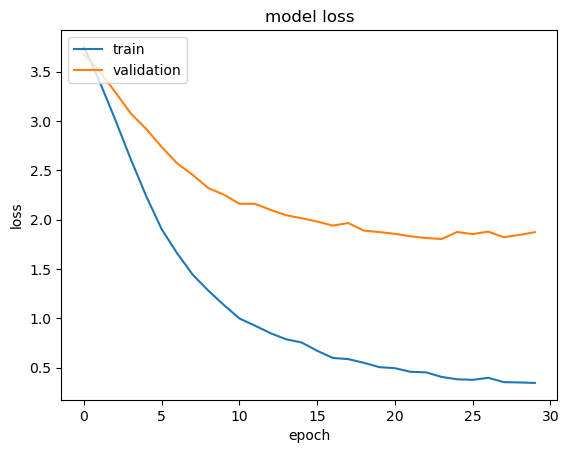

In [43]:
plt.plot(best_model_trained.history['loss'])
plt.plot(best_model_trained.history['val_loss'])

plt.legend(['train', 'validation'], loc='upper left')

ay = plt.gca()

ay.yaxis.set_major_locator(MultipleLocator(base=0.50)) 


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.savefig(os.path.join(new_results_dir,'Model_loss.png'))
plt.show()

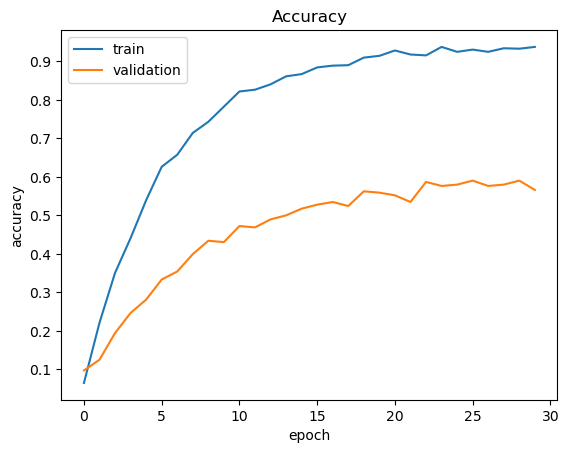

In [44]:
plt.plot(best_model_trained.history['accuracy'])
plt.plot(best_model_trained.history['val_accuracy'])


ay = plt.gca()
ay.yaxis.set_major_locator(MultipleLocator(base=0.10)) 

plt.legend(['train', 'validation'], loc='upper left')

plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.savefig(os.path.join(new_results_dir,'Model_accuracy.png'))
#plt.show()

In [45]:
predictions = best_model.predict(test_samples)

# np.argmax -> index of the element with the highest value 

predicted_labels = np.argmax(predictions, axis=1) + 1

true_label = np.argmax(test_labels, axis=1) + 1

9/9 [==============================] - 2s 9ms/step


In [46]:
joblib.dump(predictions, os.path.join(new_results_dir,'predictions.sav'))

['C:\\Users\\ilkele4s\\ML_Results\\LSTM_noFunction_singleElectrode_results\\electrode_1\\predictions.sav']

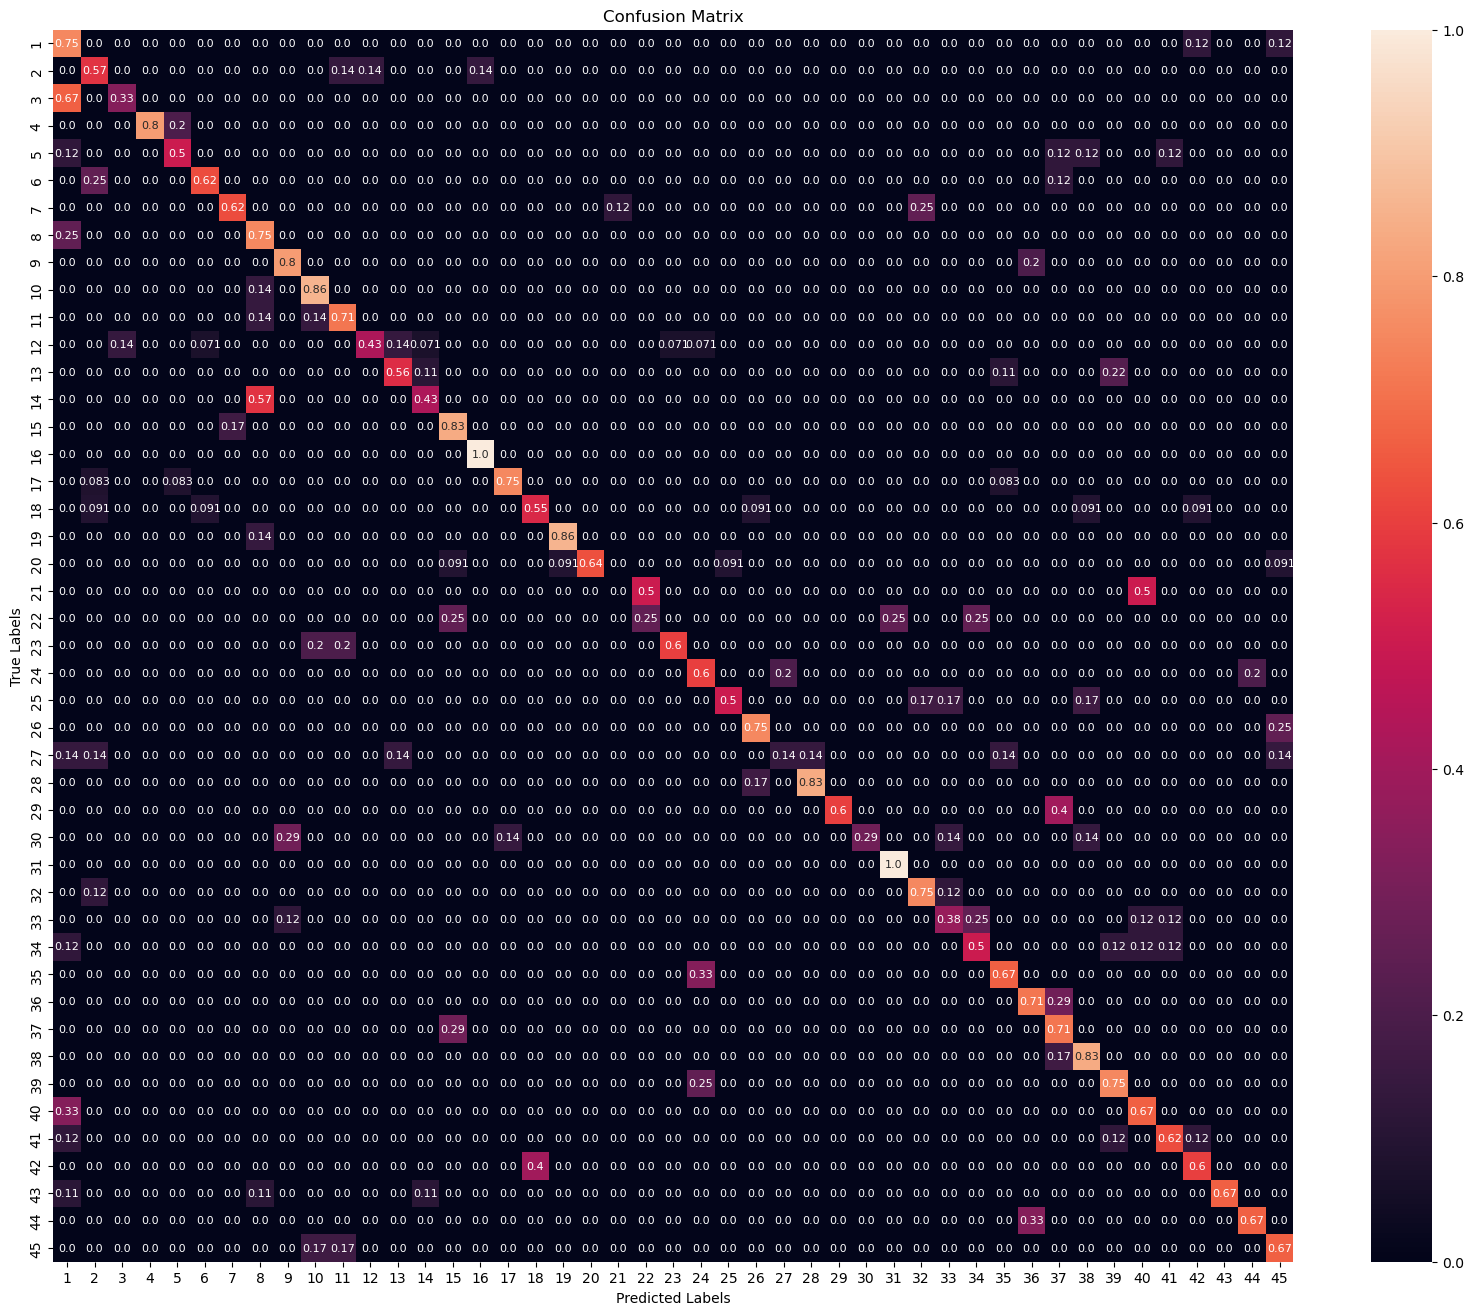

In [47]:
# creating the confusion matrix
cm = confusion_matrix(true_label, predicted_labels, normalize='true')
#%%
class_labels = [str(i) for i in range(1, 46)]
#%%
plt.figure(figsize=(20, 16))
sns.heatmap(cm, fmt='.2',annot=True, annot_kws={"size": 8}, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig(os.path.join(new_results_dir,'Cm_optim.png'))
#plt.show()

In [48]:
report = classification_report(true_label, predicted_labels, output_dict=True)

In [49]:
f1 = report['weighted avg']

In [50]:
file = open(os.path.join(new_results_dir,'F1.txt'), 'w')
# Write content to the file
file.write(str(f1))

111

In [51]:
Acc = balanced_accuracy_score(true_label, predicted_labels)
print('Weighted accuracy is:', Acc)

Weighted accuracy is: 0.6248516915183583


In [52]:
file = open(os.path.join(new_results_dir,'Acc_balanced.txt'), 'w')
# Write content to the file
file.write(str(Acc))

18

In [53]:
file.close()